In [1]:
from google.colab import drive
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Lambda, Multiply, Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re
import tensorflow.keras.backend as K
import tensorflow as tf

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
df = pd.read_csv("/content/drive/MyDrive/NN_Data/train.csv")
df = df.iloc[:, 1:]

wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = re.sub(r'http\S+|www\S+|@\S+|#\S+', '', text)
    text = "".join([char for char in text if char.isalpha() or char.isspace()])


    tokens = word_tokenize(text.lower())

    tokens = [word for word in tokens if word not in stop_words]
    tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

df['Discussion'] = df['Discussion'].apply(preprocess_text)
df = df.dropna()

In [7]:
category_mapping = {'Politics': 0, 'Sports': 1, 'Media': 2, 'Market & Economy': 3, 'STEM': 4}
df['Category'] = df['Category'].map(category_mapping)

In [8]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['Discussion']).toarray()

y = np.array(df['Category'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)

In [9]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [10]:
# Input handling remains the same until GRU implementation
input_shape = (1, X_train.shape[2])
inputs = Input(shape=input_shape)
x_t = Lambda(lambda x: x[:, 0, :])(inputs)  # x<t>

units = 128

# Initial hidden state (c<t-1> )
c_prev = Lambda(lambda x: K.zeros_like(x[:, 0, :units]), output_shape=(units,))(inputs)

# Update gate (Gu )
W_ux = Dense(units, use_bias=True)  # Wu_x
W_uc = Dense(units, use_bias=False)  # Wu_c
gu_x = W_ux(x_t)
gu_c = W_uc(c_prev)
Gu = Activation('sigmoid')(Add()([gu_x, gu_c]))  # Gu

# Reset gate (Gr )
W_rx = Dense(units, use_bias=True)  # Wr_x
W_rc = Dense(units, use_bias=False)  # Wr_c
gr_x = W_rx(x_t)
gr_c = W_rc(c_prev)
Gr = Activation('sigmoid')(Add()([gr_x, gr_c]))  # Gr

# Candidate hidden state (c̃)
W_cx = Dense(units, use_bias=True)  # Wc_x
W_cc = Dense(units, use_bias=False)  # Wc_c
gr_c_prev = Multiply()([Gr, c_prev])
c_tilde_x = W_cx(x_t)
c_tilde_c = W_cc(gr_c_prev)
c_tilde = Activation('tanh')(Add()([c_tilde_x, c_tilde_c]))  # c̃

# Current hidden state (c<t>)
one_minus_Gu = Lambda(lambda x: 1.0 - x)(Gu)
c_curr = Add()([
    Multiply()([one_minus_Gu, c_prev]),
    Multiply()([Gu, c_tilde]),
])

# Continue with the rest of the model
x = BatchNormalization()(c_curr)
x = Dropout(0.6)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
outputs = Dense(y_train.shape[1], activation='softmax')(x)

In [11]:
# Model compilation and training remain the same
model_gru_custom = Model(inputs=inputs, outputs=outputs)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=9, restore_best_weights=True)

model_gru_custom.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_gru_custom.fit(X_train, y_train, epochs=30, batch_size=64,
                               validation_data=(X_test, y_test),
                               callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model_gru_custom.evaluate(X_test, y_test, verbose=2)
print(f'Custom GRU Test Accuracy: {test_accuracy * 100:.2f}%')

# Save the model
model_gru_custom.save('tfidf_gru_custom_model.h5')

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.4740 - loss: 1.8265 - val_accuracy: 0.6475 - val_loss: 1.3984
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.7074 - loss: 0.8849 - val_accuracy: 0.6621 - val_loss: 0.9335
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.7454 - loss: 0.7295 - val_accuracy: 0.6571 - val_loss: 0.9189
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.7568 - loss: 0.6689 - val_accuracy: 0.6491 - val_loss: 0.9605
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7776 - loss: 0.6158 - val_accuracy: 0.6465 - val_loss: 0.9969
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.7818 - loss: 0.5979 - val_accuracy: 0.6403 - val_loss: 1.0494
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7918 - loss: 0.5640 - val_accuracy: 0.6407 - val_loss: 1.0995
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.7946 - loss: 0.5587 - v

Custom GRU Test Accuracy: 66.21%


In [12]:
# Predictions on test data
test_data = pd.read_csv("/content/drive/MyDrive/NN_Data/test.csv")
test_data['Discussion'] = test_data['Discussion'].apply(preprocess_text)
pred = tfidf_vectorizer.transform(test_data['Discussion']).toarray()

pred = pred.reshape(pred.shape[0], 1, pred.shape[1])
pred = model_gru_custom.predict(pred)
test_predictions = np.argmax(pred, axis=1)
result = pd.DataFrame({
    "SampleID": test_data["SampleID"].values,
    "Category": test_predictions
})
print(result.head(10))
result.to_csv('output.csv', index=False)


330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
   SampleID  Category
0         1         3
1         2         0
2         3         1
3         4         4
4         5         3
5         6         0
6         7         1
7         8         0
8         9         4
9        10         3


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1, 5000)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 5000)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 128)            │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │        640,128 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │         16,384 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 128)            │              0 │ dense_2[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128)            │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │        640,128 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         16,384 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 128)            │              0 │ activation_1[0][0],    │
│                           │                        │                │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128)            │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │        640,128 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         16,384 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128)            │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 128)            │              0 │ dense_4[0][0],         │
│                           │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 128)            │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128)            │              0 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)

 Total params: 5,935,377 (22.64 MB)

 Trainable params: 1,978,373 (7.55 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 3,956,748 (15.09 MB)

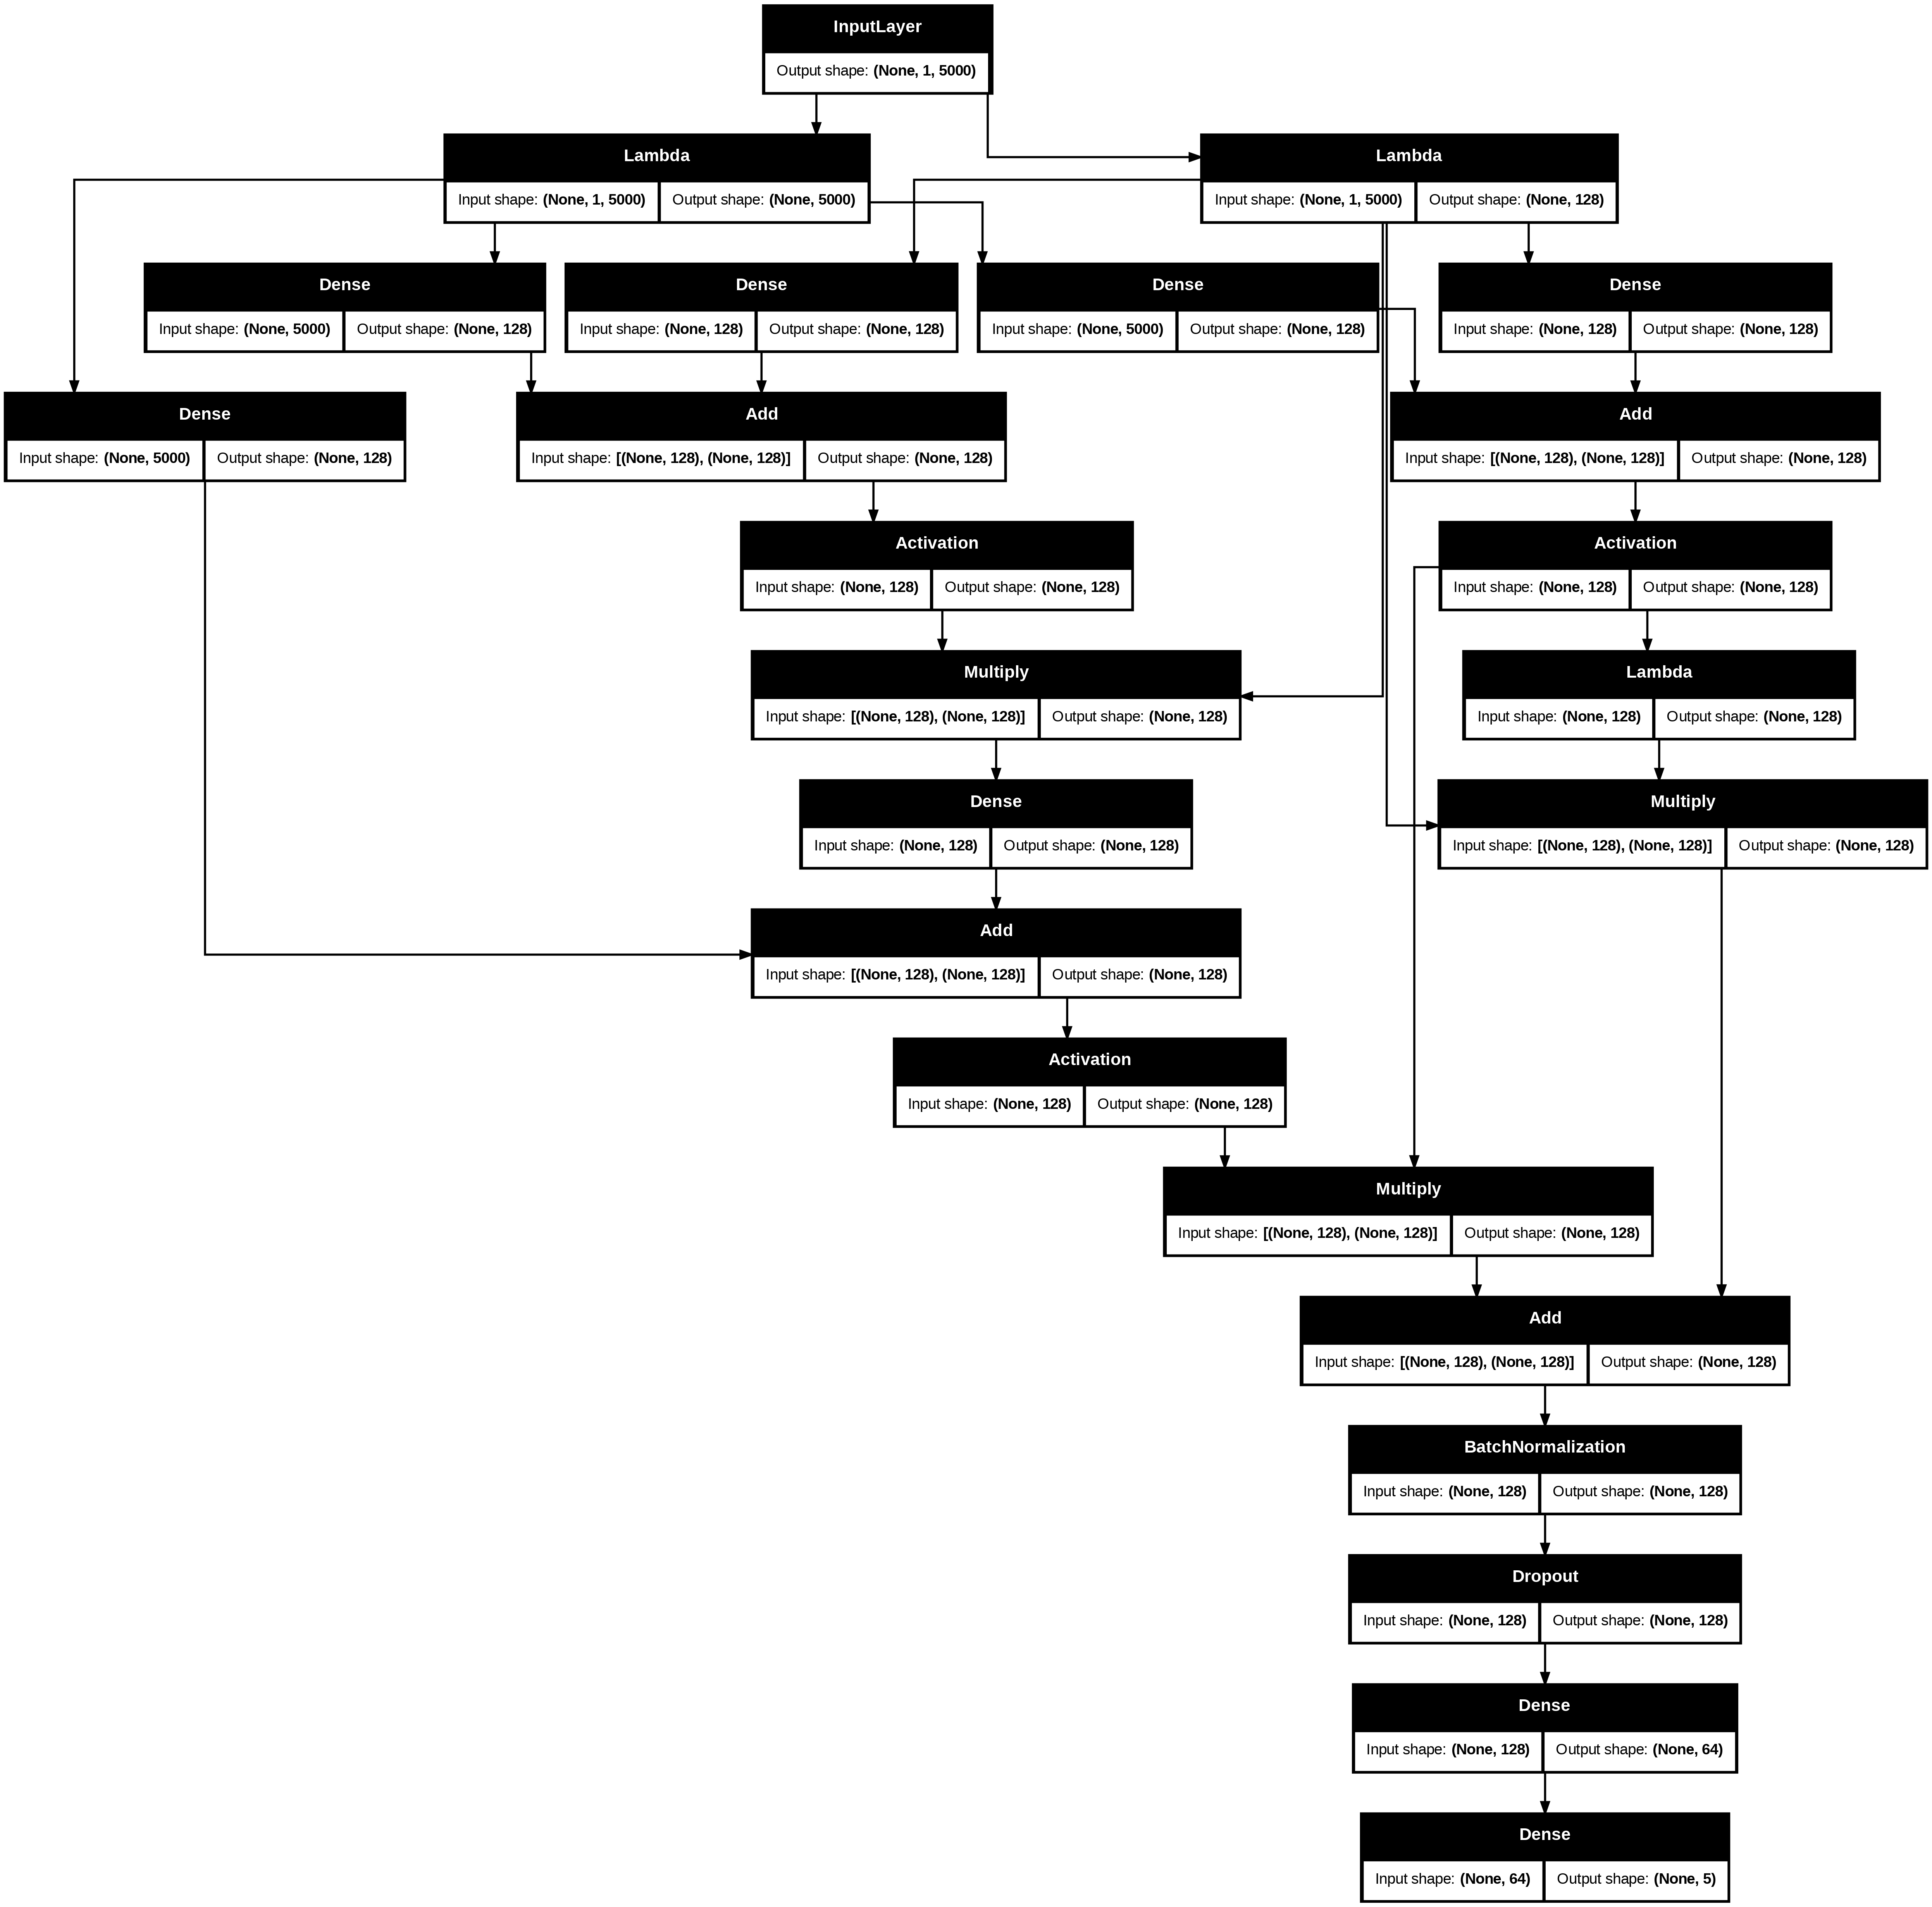

In [13]:
# Model summary and plot
model_gru_custom.summary()
tf.keras.utils.plot_model(model_gru_custom, show_shapes=True)

In [14]:
# Load the new data
from sklearn.metrics import accuracy_score
new_data = pd.read_csv("/content/drive/MyDrive/NN_Data/train.csv")

# Preprocess the text data
new_data['Discussion'] = new_data['Discussion'].apply(preprocess_text)

# Transform the text using the TF-IDF vectorizer
X_new = tfidf_vectorizer.transform(new_data['Discussion']).toarray()

# Reshape for the LSTM model
X_new = X_new.reshape(X_new.shape[0], 1, X_new.shape[1])

# Make predictions
predictions = model_gru_custom.predict(X_new)
predicted_classes = np.argmax(predictions, axis=1)

new_data['Category'] = new_data['Category'].map(category_mapping)

accuracy = accuracy_score(new_data['Category'], predicted_classes)
print(f"Accuracy on new data: {accuracy * 100:.2f}%")

# Add predictions to the new data
new_data['Predicted_Class'] = predicted_classes

# Save the results to a new CSV file
new_data.to_csv("new_data_with_predictions.csv", index=False)

print("Predictions saved to 'new_data_with_predictions.csv'")

781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
Accuracy on new data: 75.87%
Predictions saved to 'new_data_with_predictions.csv'
